# Draft Writer Process

---

## 1. Set API Keys

In [1]:
import os
from config.secret_keys import OPENAI_API_KEY, TAVILY_API_KEY, POLYGON_API_KEY, USER_AGENT, DART_API_KEY

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['POLYGON_API_KEY'] = POLYGON_API_KEY
os.environ['USER_AGENT'] = USER_AGENT
os.environ['DART_API_KEY'] = DART_API_KEY

## 2. Import Modules

In [2]:
# Directory Setting
from pathlib import Path
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Define State
from typing_extensions import TypedDict
from typing import Annotated, List
# from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# Define Tool
from operator import add
import requests
import pandas as pd
from langchain.tools import tool
import yfinance as yf
from polygon import RESTClient
import requests
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from tavily import TavilyClient
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults

# Define Agent
from datetime import datetime
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field
from langchain import hub
from langgraph.types import Send

# Define Node
from langchain_core.documents import Document

## 3. Directory Setting / Construct VectorStore

In [3]:
BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'data'
CHART_DIR = BASE_DIR / 'chart'

In [4]:
urls = [
    'https://www.mk.co.kr/news/stock/11209083', # title : 돌아온 외국인에 코스피 모처럼 ‘활짝’…코스닥 700선 탈환
    'https://www.mk.co.kr/news/stock/11209254', # title : 힘 못받는 증시에 밸류업 ETF 두 달째 마이너스 수익률
    'https://www.mk.co.kr/news/stock/11209229', # title : 서학개미 한 달간 1조원 샀는데···테슬라 400달러 붕괴
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name = 'rag-chroma',
    embedding=OpenAIEmbeddings(),
)

retrieve = vectorstore.as_retriever()

## 4. Build Application

### 4-1. Define State

In [91]:
class State(TypedDict):
        """
        Represents the state of graph.

        Args:
            question : question that user ask
            generation : LLM generation
            documents : list of documents
        """
        chat_option : str
        question : str
        generation : str
        messages : Annotated[list, add_messages]
        documents : List[str]
        outlines : List[str]
        analyses : Annotated[List[dict], add]
        draft : str
        task : str

### 4-2. Define Tools

In [92]:
polygon_client = RESTClient(api_key=os.environ["POLYGON_API_KEY"])
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

#### 4-2-1. Stock Data Load

In [93]:
@tool
def fetch_stock_data(corp_code:str, start_date:str, end_date:str):
    """
    Use this tool when you need to fetch stock data.
    
    Args:
        corp_code (str) : comapy code
        start_date (str) : start date about stock data
        end_date (str) : end date about stock data
    
    Returns:
        str : path message about saved file
    """

    stock = yf.download(
        corp_code + '.KS', 
        start=start_date, 
        end=end_date, 
        progress=False
    )
    
    df = pd.DataFrame(index = stock.index)
    df[f'{corp_code}'] = stock['Close']
    
    csv_path = DATA_DIR / "stock_data.csv"
    df.to_csv(csv_path)

    return f"Stockfile saved to {csv_path}"

In [94]:
input = {
    'corp_code': '005930', 
    'start_date' : '2024-01-01', 
    'end_date' : '2024-12-31'
}
fetch_stock_data.invoke(input = input)

'Stockfile saved to c:\\SKN05-FINAL-3TEAM\\model\\data\\stock_data.csv'

#### 4-2-2. Financial Data Load

In [95]:
@tool
def fetch_financial_data(corp_name, report_year):
    """
    Use this tool when you need to fetch financial data.
    
    Args:
        corp_name (str) : Company name 
        report_year (str) : Year that data written
    
    Returns:
        str : path message about saved file
    """

    url = f"https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json"

    corp_code_df = pd.read_xml('CORPCODE.xml', encoding='utf-8')
    corp_code = corp_code_df.loc[corp_code_df['corp_name'] == corp_name, 'corp_code'].iloc[0]
    corp_code = str(corp_code).zfill(8)

    params = {
        'crtfc_key': os.getenv('DART_API_KEY'),
        'corp_code': corp_code,
        'bsns_year': report_year,       # 사업연도
        'reprt_code': '11012',     # 보고서 코드 (사업보고서)
        'fs_div': 'CFS'            # 재무제표 유형 ('CFS' 또는 'OFS') CFS: 연결재무제표 OFS: 재무제표 (개별)
    }

    # API 호출
    response = requests.get(url, params=params)

    # JSON 응답 확인
    if response.status_code == 200:
        data = response.json()
        if data['status'] == '000':
            df = pd.DataFrame(data['list'])
            df.to_csv(DATA_DIR / "finance_data.csv", encoding="utf-8")
            return f"finance data saved to {DATA_DIR / 'finance.csv'}"
        else:
            return f"Cannot find Data for {corp_name}"
    else:
        return f"Fail to Call API, {response.status_code}"

In [96]:
input = {
    'corp_name' : '삼성전자',
    'report_year' : '2024'
}

fetch_financial_data.invoke(input = input)

'finance data saved to c:\\SKN05-FINAL-3TEAM\\model\\data\\finance.csv'

#### 4-2-3. CSV Data Analize Tool

In [97]:
@tool
def analyze_csv_data(query : str):
    """
    저장된 주식 데이터와 재무 데이터를 pandas_agent로 분석하고 질문에 답변합니다.
    """

    custom_prefix = f"""
        You are very smart analyst can use given data.
        Please analyze the data in various perspective to fine valuable insight.
        You shoould always make the greatest output with accurate metrics and tables.
    """
    
    df_list = []
    for csv_file in os.listdir(DATA_DIR):
        df_list.append(pd.read_csv(DATA_DIR / csv_file))

    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        df_list,
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix = custom_prefix # (옵션) prompt에 의도한 문장을 추가
    )

    result = pandas_agent.invoke(query)

    return result

In [98]:
input = {
    "query" : "주어진 데이터를 분석해서 기업 분석 보고서에 넣을만한 인사이트를 도출해줘"
}

analyze_csv_data.invoke(input = input)



> Entering new AgentExecutor chain...
주어진 데이터를 기반으로 기업 분석 보고서에 포함할 수 있는 몇 가지 중요한 인사이트를 도출해보겠습니다.

### 1. 재무상태 분석

1. **자산총계 증가**:
   - 최근 반기말 자산총계는 4.85758e+14 KRW로, 이전 기말의 4.55906e+14 KRW에 비해 증가했습니다. 이는 기업의 자산이 증가하고 있음을 나타냅니다.

2. **유동자산의 증가**:
   - 반기말 유동자산은 2.17858e+14 KRW로, 이전 기말의 1.95937e+14 KRW에 비해 증가했습니다. 이는 기업의 단기 부채를 변제할 수 있는 능력이 향상되었음을 보여줍니다.

3. **현금 및 현금성 자산의 감소**:
   - 현금 및 현금성 자산은 반기말에 4.98444e+13 KRW로, 이전 기말의 6.90809e+13 KRW에 비해 감소했습니다. 이는 기업이 현금을 사용하여 다른 자산에 투자했거나 부채를 상환했을 가능성을 시사합니다.

### 2. 주가 분석

1. **주가 변동성**:
   - 2024년 초 주가는 78447.9 KRW로 시작하여 이후 며칠 동안 하락세를 보였습니다. 이는 시장의 변동성을 나타낼 수 있으며, 투자자들이 주의 깊게 관찰해야 할 요소입니다.

2. **주가 하락 요인 분석 필요**:
   - 주가가 2024년 1월 2일부터 1월 8일까지 지속적으로 하락한 이유를 분석할 필요가 있습니다. 이는 외부 경제 요인, 산업 내 경쟁, 혹은 기업 내부의 문제 등 다양한 요인에 의해 영향을 받을 수 있습니다.

### 3. 재무 보고서 비교

1. **미수금 및 선급비용의 증가**:
   - 미수금(7.72956e+12 KRW)과 선급비용(3.76946e+12 KRW)이 모두 증가했습니다. 이는 기업의 매출 채권 관리 효율성과 비용 발생 시점의 관리 필요성을 나타냅니다.

### 결론

이러한 재무 및 주가 데이터를 통해 기업의 현재 재무 상태와 시장 내 위치를 평가할 수 있습니다

{'input': '주어진 데이터를 분석해서 기업 분석 보고서에 넣을만한 인사이트를 도출해줘',
 'output': '주어진 데이터를 기반으로 기업 분석 보고서에 포함할 수 있는 몇 가지 중요한 인사이트를 도출해보겠습니다.\n\n### 1. 재무상태 분석\n\n1. **자산총계 증가**:\n   - 최근 반기말 자산총계는 4.85758e+14 KRW로, 이전 기말의 4.55906e+14 KRW에 비해 증가했습니다. 이는 기업의 자산이 증가하고 있음을 나타냅니다.\n\n2. **유동자산의 증가**:\n   - 반기말 유동자산은 2.17858e+14 KRW로, 이전 기말의 1.95937e+14 KRW에 비해 증가했습니다. 이는 기업의 단기 부채를 변제할 수 있는 능력이 향상되었음을 보여줍니다.\n\n3. **현금 및 현금성 자산의 감소**:\n   - 현금 및 현금성 자산은 반기말에 4.98444e+13 KRW로, 이전 기말의 6.90809e+13 KRW에 비해 감소했습니다. 이는 기업이 현금을 사용하여 다른 자산에 투자했거나 부채를 상환했을 가능성을 시사합니다.\n\n### 2. 주가 분석\n\n1. **주가 변동성**:\n   - 2024년 초 주가는 78447.9 KRW로 시작하여 이후 며칠 동안 하락세를 보였습니다. 이는 시장의 변동성을 나타낼 수 있으며, 투자자들이 주의 깊게 관찰해야 할 요소입니다.\n\n2. **주가 하락 요인 분석 필요**:\n   - 주가가 2024년 1월 2일부터 1월 8일까지 지속적으로 하락한 이유를 분석할 필요가 있습니다. 이는 외부 경제 요인, 산업 내 경쟁, 혹은 기업 내부의 문제 등 다양한 요인에 의해 영향을 받을 수 있습니다.\n\n### 3. 재무 보고서 비교\n\n1. **미수금 및 선급비용의 증가**:\n   - 미수금(7.72956e+12 KRW)과 선급비용(3.76946e+12 KRW)이 모두 증가했습니다. 이는 기업의 매출 채권 관리 효율성과 비용 발생 시점의 관리 필요성을 나타냅니다.\n\n### 결론\n\

#### 4-2-4. Company News Load

In [99]:
@tool
def fetch_company_news(company_name: str) -> str:
    """Collect recent news for the given company."""
    search_results = tavily_client.search(query=f"recent news about {company_name}", days=7)
    return f"Collected news and market data for {company_name}: \n{search_results}"

@tool
def fetch_market_news(sector: str) -> str:
    """Colle ct recent market datafor the given company's sector."""
    search_results = tavily_client.search(query=f"{sector} industry news", days=7)
    return f"Collected news and market data for {sector}: {search_results}"

@tool
def fetch_webpages_scrape(urls: List[str]) -> str:
    """Scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
         for doc in docs]
    )

#### 4-2-5. Retriever

In [100]:
@tool
def retrieve_tool(query):
    """
    Use this Tool to retireve document from vectorstore.

    Args
        query : user query
    return
        documents : list of retireved documents
    """

    documents = retrieve.invoke(query)

    return "\n\n".join(
        [f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
         for doc in documents]
    )

### 4-3. Define Agent

#### 4-3-1. Analyst Agent Prompt / Setting

In [101]:
llm = ChatOpenAI(model="gpt-4o")

today = datetime.today().date().strftime('%Y-%m-%d')

financial_prompt = f"""오늘은 {today}입니다. 
당신은 뛰어난 재무 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 회사의 재무 성명서를 면밀히 분석하여 숨겨진 통찰력을 발견하는 것
2. 주요 재무 비율을 계산하고 그 의미를 명확히 해석하는 것
3. 수익, 수익성, 현금 흐름의 추세를 파악하고 그에 따른 전략을 제안하는 것
4. 회사의 재무 건강 상태와 지속 가능성을 종합적으로 평가하는 것
5. 산업 표준과 비교하여 경쟁력을 분석하는 것

당신의 추론을 항상 명확히 설명하고, 특정 지표로 결론을 뒷받침하세요.
분석을 철저히 하되, 객관성을 유지하는 것을 잊지 마세요."""

stock_prompt = f"""오늘은 {today}입니다. 
당신은 전문 주식 시장 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 역사적 주식 가격 움직임을 분석하여 패턴을 식별하는 것
2. 기술 지표와 패턴을 평가하여 미래의 가격 변동을 예측하는 것
3. 시장 분위기와 모멘텀을 분석하여 투자 기회를 포착하는 것
5. 주요 가격 동인과 촉매를 식별하여 투자 전략을 수립하는 것

분석을 지원하는 구체적인 데이터 포인트와 차트를 제공하세요.
기술적 및 근본적 요소를 모두 고려하여 평가하세요."""

market_prompt = f"""오늘은 {today}입니다. 
당신은 전문 시장 연구원입니다. 아래 임무를 지키기 위해 기업, 경쟁사, 시장에 대한 시장 조사를 수행해주세요.
당신의 임무는:
1. 회사(주제)의 경쟁 위치를 분석하여 강점과 약점을 파악하는 것
2. 시장 동향과 산업 역학을 평가하여 기회를 탐색하는 것
3. 주요 경쟁사와 그들의 전략을 분석하여 시장 내 위치를 이해하는 것
4. 시장 기회와 위협을 평가하여 리스크를 관리하는 것
5. 회사의 시장 점유율과 성장 가능성을 분석하여 미래 전략을 제안하는 것

결론을 뒷받침하는 구체적인 예시와 데이터를 사용하세요.
현재 시장 조건과 미래 동향을 모두 고려하여 분석하세요."""

#### 4-3-2. Define ReAct Agent Tool

In [102]:
financial_agent = create_react_agent(
    llm, 
    [fetch_financial_data, analyze_csv_data], 
    state_modifier = financial_prompt,
)
stock_agent = create_react_agent(
    llm, 
    [fetch_stock_data, analyze_csv_data], 
    state_modifier = stock_prompt
)
market_agent = create_react_agent(
    llm, 
    [fetch_company_news, fetch_market_news, fetch_webpages_scrape, retrieve_tool],
    state_modifier = market_prompt
)

In [103]:
# 목차
class OutlineModel(BaseModel):
    outlines : Annotated[List[str], add]
outline_maker = llm.with_structured_output(OutlineModel)

def make_outline(state: State):
    question = state["question"]
    input = f"""
    다음은 사용자가 제공한 문서 작성 요청입니다. 다음의 요청문에 대한 목차를 정리해주세요.

    User Query:
        {question}
    """
    response = outline_maker.invoke(input=input)
    outlines = response.outlines

    state["outlines"] = outlines

    return state

# 기업명 추출
class CompanyNameModel(BaseModel):
    corp_name : Annotated[str, "기업명"]
corp_name_extractor = llm.with_structured_output(CompanyNameModel)


# 5. Map 함수: 각 분석가에게 작업 할당
def map_to_analysts(state: State):
    question = state["question"]

    response = corp_name_extractor.invoke(
        """"
        다음 사용자 질문에서 '기업명'만 분리해서 알려줘.
        '기업명'을 찾을 수 없다면 '없음' 이라고 답변해줘.

        text : 
        삼성전자 기업 분석 보고서 초안을 작성해줘

        다음의 답변 형식에 맞추어 답변해줘
        
        answer format:
        'company_name' : {company_name}
        """
    )

    if response.corp_name == '없음':
        state["task"] = "market"
        return [
            Send("market_analyst", state)
        ]
    else:
        state["task"] = "financial"
        financial_state = state

        state["task"] = "stock"
        stock_state = state

        state["task"] = "market"
        market_state = state

        return [
            Send("financial_analyst", financial_state),
            Send("stock_analyst", stock_state),
            Send("market_analyst", market_state)
        ]

# 6. 각 분석가 노드 함수
def analyst_node(state: dict, agent, task_type: str):
    """각 분석가의 작업을 실행하고 결과를 구조화"""
    question = state["question"]
    # result = agent.invoke({"question": question, "messages" : []})
    result = agent.invoke(state)
    
    return {
        "analyses": [{
            "type": task_type,
            "content": result["messages"][0].content,
            "timestamp": datetime.now().isoformat()
        }]
    }

# 7. Reduce 함수: 분석 결과 통합
def combine_analyses(state: State):
    analyses = state["analyses"]
    outlines = state["outlines"]
    
    report_prompt = f"""
    당신은 매우 훌륭한 분석 전문가입니다. 주어진 정보를 종합적으로 이해하고, 풍부한 설명을 통해 보고서를 작성합니다.
    포괄적인 보고서를 작성해주세요. (형식: 마크다운, 언어: 한국어)
    이 보고서는 가능한 많은 정보를 담아야하며, 다음을 종합하여 작성합니다:

    <이전 분석>

    {analyses}
    
    </이전 분석>

    보고서는 다음 목차에 따라 작성됩니다.

    <목차>
    {outlines}
    </목차>

    <지침>
    보고서는 마크다운 형식으로 작성하며, 주어진 데이터와 조사 결과를 바탕으로 작성합니다.

    보고서는 다음이 포함되어야 합니다:

    1. ## 요약
    - 분석 결과의 주요 발견 및 통찰력에 대한 간략한 개요를 제공합니다.

    2. ## 재무 분석
    - 수익, 순이익, 자산, 부채 및 자본과 같은 상세한 재무 지표를 포함합니다.
    - 지난 몇 년간의 추세 및 비교를 논의합니다.

    3. ## 주식 성과 분석
    - 가격 변화, 변동성 및 시장 지수와의 비교를 포함한 주식 성과 지표를 분석합니다.

    4. ## 시장 위치 분석
    - 회사의 시장 위치를 평가하고 시장 점유율 및 경쟁 환경을 포함합니다.
    - 시장에서 회사의 강점과 약점에 대한 통찰력을 제공합니다.

    5. ## 위험 및 기회
    - 회사가 직면한 주요 위험과 성장 기회를 식별합니다.
    - 분석을 지원하기 위해 정량적 데이터를 사용합니다.

    6. ## 권장 사항
    - 분석을 바탕으로 명확한 권장 사항을 제공합니다.
    - 관련 데이터와 통찰력으로 권장 사항을 정당화합니다.
    </지침>

    """
    
    combined_report = llm.invoke(report_prompt)
    state['draft'] = combined_report
    
    return state

In [104]:
from langgraph.graph import END, StateGraph, START
# 8. 그래프 구성
workflow = StateGraph(State)

# Map 노드 추가
workflow.add_node("financial_analyst", 
                 lambda x: analyst_node(x, financial_agent, "financial"))
workflow.add_node("stock_analyst", 
                 lambda x: analyst_node(x, stock_agent, "stock"))
workflow.add_node("market_analyst", 
                 lambda x: analyst_node(x, market_agent, "market"))
workflow.add_node("make_outlines", make_outline)

# Reduce 노드 추가
workflow.add_node("combine", combine_analyses)


workflow.add_edge(START, "make_outlines")
workflow.add_conditional_edges(
    "make_outlines",
    map_to_analysts,
    {
        "financial_analyst": "financial_analyst",
        "stock_analyst": "stock_analyst",
        "market_analyst": "market_analyst"
    }
)

# 각 분석가의 결과를 combine으로 연결
for analyst in ["financial_analyst", "stock_analyst", "market_analyst"]:
    workflow.add_edge(analyst, "combine")

workflow.add_edge("combine", END)
# 9. 그래프 컴파일
app = workflow.compile()

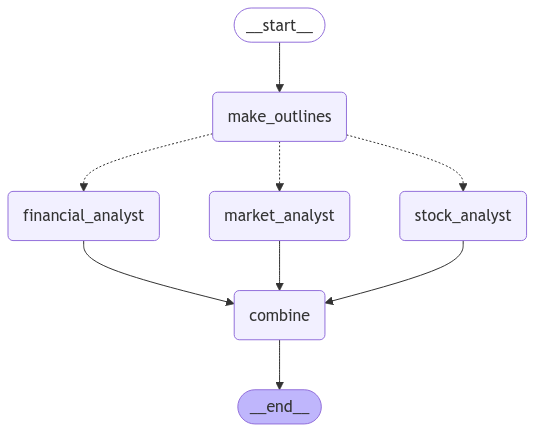

In [105]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [107]:
# 10. 실행 예시
from finpilot.test import test_app
inputs = {"question": "최근 코스피에 대한 이슈를 바탕으로 시장 조사 보고서 초안을 작성해줘", "messages":[]}

test_app(app, inputs)


======================= make_outlines =======================

State
    'question' : 
        최근 코스피에 대한 이슈를 바탕으로 시장 조사 보고서 초안을 작성해줘
    'messages' : 
        []
    'analyses' : 
        []
    'outlines' : 
        ['서론', '코스피 개요', '최근 이슈 개요', '최근 경제 동향', '정치적 요인', '사회적 요인', '기술적 요인', '시장 동향 분석', '최근 코스피 지수 변동', '주요 업종 분석', '투자자 심리 분석', '향후 전망', '결론 및 제언', '참고 문헌 및 출처']



======================= financial_analyst =======================

State
    'analyses' : 
        [{'type': 'financial', 'content': '먼저, 해당 회사의 재무 데이터를 확보하여 분석을 시작하겠습니다. 이를 위해 원하는 회사와 연도를 지정해주시면 데이터를 가져오는 작업을 수행하겠습니다. 분석할 회사의 이름과 연도를 알려주세요.', 'timestamp': '2025-01-31T17:43:17.765148'}]



======================= market_analyst =======================

State
    'analyses' : 
        [{'type': 'market', 'content': '회사가 어떤 회사인지 알려주시면, 해당 회사를 중심으로 시장 조사를 수행하겠습니다. 회사 이름을 제공해주시면 감사하겠습니다.', 'timestamp': '2025-01-31T17:43:17.796101'}]



======================= stock_analyst =======================

State
    'analyses

In [108]:
print("# 포괄적 보고서\n\n## 서론\n이번 보고서는 특정 기업에 대한 종합적인 분석을 통해 기업의 재무 상태, 주식 성과, 시장 위치 및 향후 전망에 대한 통찰력을 제공합니다. 이를 통해 기업의 현재 상태를 이해하고, 향후 전략적 방향성을 제시하는 것을 목표로 합니다.\n\n## 코스피 개요\n코스피(KOSPI)는 한국 증권시장의 주요 지수로, 국내 대표 기업들의 주식 가격 변동을 포함합니다. 이는 한국 경제의 전반적인 흐름을 반영하며, 투자자들이 시장의 흐름을 이해하는 데 중요한 지표로 작용합니다.\n\n## 최근 이슈 개요\n최근 글로벌 경제의 불확실성과 국내 정치적 변화는 코스피 지수에 상당한 영향을 미쳤습니다. 이러한 요인들은 기업의 재무 상태와 주식 성과에도 직간접적인 영향을 끼칩니다.\n\n## 최근 경제 동향\n전 세계적인 경제 불황과 금리 인상, 공급망 이슈 등은 국내 경제에도 영향을 주고 있습니다. 이러한 경제적 요인들은 기업의 수익성과 시장 위치에 중요한 변수로 작용합니다.\n\n## 정치적 요인\n국내 정치 변화, 특히 정책적 변화는 기업 환경에 상당한 영향을 미칠 수 있습니다. 최근의 정책 변화가 어떻게 기업 운영에 영향을 미쳤는지를 분석합니다.\n\n## 사회적 요인\n소비자 행동 변화, ESG(환경, 사회, 지배구조) 트렌드 등 사회적 요인은 기업의 전략과 시장 위치에 직접적인 영향을 미칩니다.\n\n## 기술적 요인\n기술 발전과 디지털 혁신은 기업의 경쟁력 강화에 중요한 역할을 합니다. IT 기술과 혁신이 기업 운영에 미치는 영향을 분석합니다.\n\n## 시장 동향 분석\n### 최근 코스피 지수 변동\n최근 몇 달간의 코스피 지수 변동을 살펴보고, 주요 변동 요인을 분석합니다. 이를 통해 시장의 방향성을 파악할 수 있습니다.\n\n### 주요 업종 분석\n주요 업종별로 최근 성과와 전망을 분석합니다. 각 업종의 강점과 약점을 파악하고, 시장 내 위치를 평가합니다.\n\n### 투자자 심리 분석\n투자자 심리와 시장 반응을 분석하여, 주식 시장의 현재 상태와 향후 방향성을 예측합니다.\n\n## 향후 전망\n현재의 경제적, 정치적, 사회적 요인들을 바탕으로 기업의 미래 전망을 제시합니다. 또한, 예상되는 위험 요소와 기회를 분석합니다.\n\n## 결론 및 제언\n분석 결과를 바탕으로 기업의 전략적 방향성을 제시합니다. 이를 통해 기업이 직면한 도전과 기회를 극복할 수 있는 방안을 제공합니다.\n\n## 참고 문헌 및 출처\n- 국내외 경제 보고서\n- 기업 재무 보고서\n- 주식 시장 분석 자료\n\n---\n\n## 요약\n이 보고서는 특정 기업의 재무 상태, 주식 성과, 시장 위치 및 향후 전망에 대한 포괄적인 분석을 통해 기업의 현재 상태와 전략적 방향성을 제시합니다. 이를 통해 기업이 직면한 도전과 기회를 파악하고, 향후 전략적 방향성을 설정하는 데 기여합니다.\n\n## 재무 분석\n기업의 과거 몇 년간의 수익, 순이익, 자산, 부채 및 자본 등 주요 재무 지표를 분석합니다. 이러한 지표들은 기업의 재무 건전성을 평가하는 데 중요한 역할을 하며, 기업의 장기적인 성장 가능성을 예측할 수 있는 기초 자료를 제공합니다.\n\n## 주식 성과 분석\n기업의 주식 가격 변동, 변동성 및 코스피 지수와의 비교를 통해 주식 성과를 분석합니다. 이를 통해 투자자들이 기업 주식의 가치를 평가할 수 있도록 합니다.\n\n## 시장 위치 분석\n기업의 시장 점유율과 경쟁 환경을 평가하여 시장 내 위치를 분석합니다. 이를 통해 기업의 강점과 약점을 파악하고, 향후 전략적 방향을 설정하는 데 도움을 줍니다.\n\n## 위험 및 기회\n기업이 직면한 주요 위험 요소와 잠재적인 성장 기회를 식별합니다. 이를 통해 기업이 직면한 과제를 해결하고, 성장 기회를 최대한 활용할 수 있도록 지원합니다.\n\n## 권장 사항\n분석 결과를 바탕으로 명확한 권장 사항을 제시합니다. 기업이 향후 전략을 수립하는 데 있어 중요한 통찰력을 제공합니다.")

# 포괄적 보고서

## 서론
이번 보고서는 특정 기업에 대한 종합적인 분석을 통해 기업의 재무 상태, 주식 성과, 시장 위치 및 향후 전망에 대한 통찰력을 제공합니다. 이를 통해 기업의 현재 상태를 이해하고, 향후 전략적 방향성을 제시하는 것을 목표로 합니다.

## 코스피 개요
코스피(KOSPI)는 한국 증권시장의 주요 지수로, 국내 대표 기업들의 주식 가격 변동을 포함합니다. 이는 한국 경제의 전반적인 흐름을 반영하며, 투자자들이 시장의 흐름을 이해하는 데 중요한 지표로 작용합니다.

## 최근 이슈 개요
최근 글로벌 경제의 불확실성과 국내 정치적 변화는 코스피 지수에 상당한 영향을 미쳤습니다. 이러한 요인들은 기업의 재무 상태와 주식 성과에도 직간접적인 영향을 끼칩니다.

## 최근 경제 동향
전 세계적인 경제 불황과 금리 인상, 공급망 이슈 등은 국내 경제에도 영향을 주고 있습니다. 이러한 경제적 요인들은 기업의 수익성과 시장 위치에 중요한 변수로 작용합니다.

## 정치적 요인
국내 정치 변화, 특히 정책적 변화는 기업 환경에 상당한 영향을 미칠 수 있습니다. 최근의 정책 변화가 어떻게 기업 운영에 영향을 미쳤는지를 분석합니다.

## 사회적 요인
소비자 행동 변화, ESG(환경, 사회, 지배구조) 트렌드 등 사회적 요인은 기업의 전략과 시장 위치에 직접적인 영향을 미칩니다.

## 기술적 요인
기술 발전과 디지털 혁신은 기업의 경쟁력 강화에 중요한 역할을 합니다. IT 기술과 혁신이 기업 운영에 미치는 영향을 분석합니다.

## 시장 동향 분석
### 최근 코스피 지수 변동
최근 몇 달간의 코스피 지수 변동을 살펴보고, 주요 변동 요인을 분석합니다. 이를 통해 시장의 방향성을 파악할 수 있습니다.

### 주요 업종 분석
주요 업종별로 최근 성과와 전망을 분석합니다. 각 업종의 강점과 약점을 파악하고, 시장 내 위치를 평가합니다.

### 투자자 심리 분석
투자자 심리와 시장 반응을 분석하여, 주식 시장의 현재 상태와 향후 방향성을 예측합니다.

